In [15]:
import gymnasium as gym
import numpy as np


max_episode_steps = 64
env = gym.make('FetchPush-v2', max_episode_steps=max_episode_steps, autoreset=True)

/home/evgeny/anaconda3/lib/python3.11/site-packages/gymnasium/envs/registration.py:877: UserWarning: WARN: `gymnasium.make(..., autoreset=True)` is deprecated and will be removed in v1.0
  logger.warn(


In [16]:
env.action_space, env.observation_space

(Box(-1.0, 1.0, (4,), float32),
 Dict('achieved_goal': Box(-inf, inf, (3,), float64), 'desired_goal': Box(-inf, inf, (3,), float64), 'observation': Box(-inf, inf, (25,), float64)))

In [17]:
class RandomAgent:
    def get_action(self, state):
        return env.action_space.sample()

In [18]:
env.reset()

({'observation': array([ 1.34815922e+00,  7.48950902e-01,  4.13618685e-01,  1.21323380e+00,
          6.78991616e-01,  4.24702091e-01, -1.34925423e-01, -6.99592861e-02,
          1.10834063e-02, -1.50944836e-06,  1.25159772e-03, -8.82449685e-08,
          1.35761490e-07,  4.67863609e-15,  9.30919601e-04, -4.11979931e-05,
          3.89350461e-05,  5.03907166e-08, -7.75241793e-08,  2.87432303e-20,
         -9.30921536e-04,  4.11967353e-05,  7.89271962e-06,  3.79757618e-07,
          4.39314913e-05]),
  'achieved_goal': array([1.2132338 , 0.67899162, 0.42470209]),
  'desired_goal': array([1.35015074, 0.71885725, 0.42469975])},
 {})

In [19]:
env.step(env.action_space.sample())

({'observation': array([ 1.34006571e+00,  7.55193797e-01,  4.15705423e-01,  1.21323380e+00,
          6.78991615e-01,  4.24737381e-01, -1.26831909e-01, -7.62021814e-02,
          9.03195859e-03,  0.00000000e+00,  0.00000000e+00, -5.03884423e-08,
          7.75206804e-08,  6.42184157e-16,  8.85878196e-03, -6.58148497e-03,
         -1.31454499e-03,  2.85323085e-08, -4.38958592e-08,  3.06703947e-18,
         -8.85878306e-03,  6.58148426e-03,  1.34121054e-03, -1.15803447e-05,
          6.58737033e-03]),
  'achieved_goal': array([1.2132338 , 0.67899162, 0.42473738]),
  'desired_goal': array([1.35015074, 0.71885725, 0.42469975])},
 -1.0,
 False,
 False,
 {'is_success': 0.0})

In [20]:
random_agent = RandomAgent()

In [21]:
from tqdm import tqdm

def play_game(agent):
    state = env.reset()
    done = False
    score = 0.0
    for i in range(max_episode_steps):
        action = agent.get_action(state)
        next_state, reward, done, _, _ = env.step(action)
        
        score += reward
        state = next_state
        if done:
            break
    return score

100%|██████████| 10/10 [00:01<00:00,  8.13it/s]


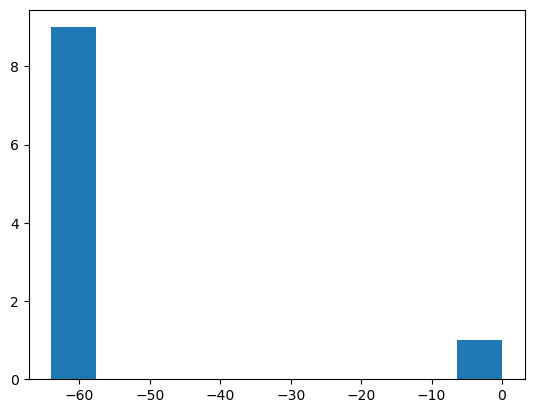

-57.6

In [22]:
import matplotlib.pyplot as plt
import numpy as np
tests = []
for i in tqdm(range(10)):
    result = play_game(random_agent)
    tests.append(result)
    
plt.hist(tests) 
plt.show()
np.mean(tests)

In [23]:
state_dim = env.observation_space['observation'].shape[0]
goal_dim = env.observation_space['desired_goal'].shape[0]
actions_dim = env.action_space.shape[0]
state_dim, actions_dim

(25, 4)

In [24]:
from soft_actor_critic import SoftActorCritic
from replay_buffer import ReplayBuffer

agent = SoftActorCritic(state_dim + goal_dim, actions_dim)
replay_buffer = ReplayBuffer(10000)
batch_size = 3

In [25]:
from her import HindsightExperienceReplay

her = HindsightExperienceReplay(env, agent, replay_buffer, 
                                batch_size=batch_size, max_steps=max_episode_steps)

In [26]:
her.play_and_learn()

-64.0

In [27]:
epochs = 100
epoch_iters = 400
success_history = []

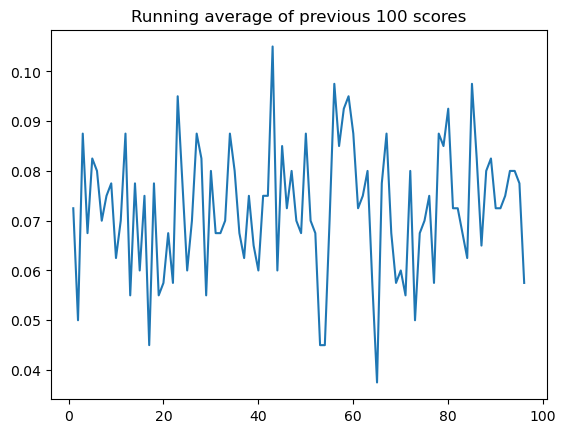

Epoch 50 success rate = 0.06


In [30]:
from tqdm import tqdm
import numpy as np
from utils import plot_learning_curve

for epoch in range(epochs):
    score_history = []
    for iter in tqdm(range(epoch_iters)):
        score = her.play_and_learn()
        score_history.append(score != -64)
    
    success_rate = np.mean(score_history)
    success_history.append(success_rate)
    plot_learning_curve(len(success_history), success_history) 
    print(f"Epoch {epoch + 1} success rate = {success_rate :.2f}")

In [ ]:
success_history

[0.0525,
 0.075,
 0.1025,
 0.0725,
 0.0625,
 0.0525,
 0.06,
 0.045,
 0.0875,
 0.07,
 0.09,
 0.0975,
 0.085,
 0.085,
 0.065,
 0.08,
 0.085,
 0.0675,
 0.09,
 0.09,
 0.09,
 0.0725,
 0.0825,
 0.125,
 0.08,
 0.08,
 0.0725,
 0.09,
 0.0775,
 0.0625,
 0.07,
 0.1,
 0.0925,
 0.0725,
 0.0975,
 0.1,
 0.0975,
 0.0875,
 0.0675,
 0.065,
 0.0875,
 0.0875,
 0.095,
 0.065,
 0.06,
 0.0775,
 0.0525,
 0.09,
 0.07,
 0.06]

In [ ]:
# def play_and_record(env, agent, buffer):
#     state = env.reset()[0]
#     # print(state)
#     done = False
#     score = 0
#     for i in range(max_episode_steps):
#         obs = state['observation']#.astype(np.float32)
#         # print(obs)
#         action = agent.choose_action(obs)
#         # print(action)
#         next_state, reward, done, _, _ = env.step(action)
#         score += reward
#         # print(obs, action, reward, next_state['observation'], done)
#         buffer.add(obs, action, reward, next_state['observation'], done)
        
#         if len(buffer) > batch_size:
#             batch = replay_buffer.sample(batch_size)
#             agent.learning_step(batch)
            
#         state = next_state
#         if done:
#             break
    
#     return score

In [ ]:
# from tqdm import tqdm
# import numpy as np
# from utils import plot_learning_curve

# n_epochs = 50
# n_episodes_per_ehoch = 100
# batch_size = 64
# # score_history = []
# best_score = env.reward_range[0]
# plts = []
# for epoch in tqdm(range(n_epochs)):
#     score_history = []
#     for i in range(n_episodes_per_ehoch):
#         score = play_and_record(env, agent, replay_buffer)
#         # if len(replay_buffer) >= batch_size:
#         #     batch = replay_buffer.sample(batch_size)
#         #     agent.learning_step(batch)
#         score_history.append(score != -max_episode_steps)
#         avg_score = np.mean(score_history[-100:])
#         if avg_score > best_score:
#             best_score = avg_score
#         # if i % 10 == 0 and i > 0:
#         #     print(f"iteration {i} score {score:.3f} avg_score {avg_score:.3f}")
#     plts.append(np.mean(score_history))
#     plot_learning_curve(epoch + 1, plts) 

In [ ]:
# agent = SoftActorCritic()